In [24]:
import pandas as pd
import numpy as np
train = pd.read_csv('../data/train.csv')
test  = pd.read_csv('../data/test.csv')

X = train.drop('label', axis=1).values.astype('float32') / 255.0
y = train['label'].values
X_test = test.values.astype('float32') / 255.0


X = X.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [25]:
print("X_train:", X_train.shape)
print("X_val:  ", X_val.shape)
print("y_train:", y_train.shape)
print("y_val:  ", y_val.shape)
print("X_test: ", X_test.shape)


X_train: (33600, 28, 28, 1)
X_val:   (8400, 28, 28, 1)
y_train: (33600,)
y_val:   (8400,)
X_test:  (28000, 28, 28, 1)


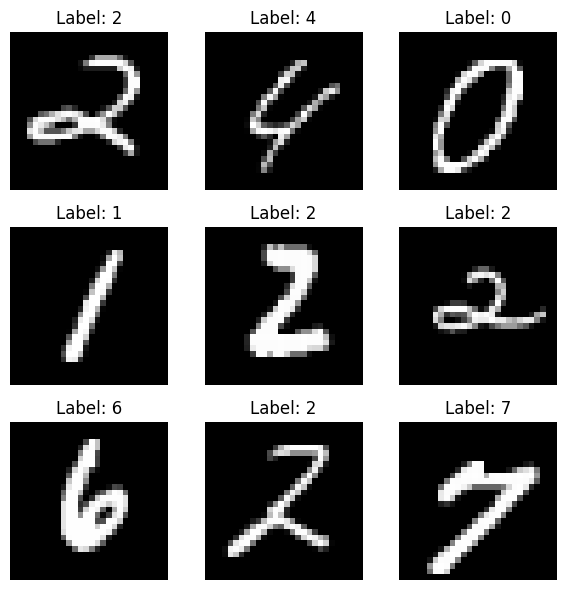

In [26]:
import matplotlib.pyplot as plt
import numpy as np
# Visa 9 slumpmässiga bilder från träningssetet
plt.figure(figsize=(6,6))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    idx = np.random.randint(0, X_train.shape[0])
    plt.imshow(X_train[idx].reshape(28,28), cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Träna modellen på vektorer istället för bilder
clf = LogisticRegression(max_iter=1000, n_jobs=-1)
clf.fit(X_train.reshape(len(X_train), -1), y_train)

# Gör prediktioner och mät noggrannhet
preds = clf.predict(X_val.reshape(len(X_val), -1))
print("Baseline validation accuracy:", accuracy_score(y_val, preds))


Baseline validation accuracy: 0.9133333333333333


In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout

def make_cnn(input_shape=(28,28,1), n_classes=10):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3,3), activation='relu'),
        MaxPool2D((2,2)),

        Conv2D(64, (3,3), activation='relu'),
        MaxPool2D((2,2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),

        Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = make_cnn()
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

# Bygg modellen (antingen den gamla eller den nya med Input-lager)
model = make_cnn()

# EarlyStopping för att undvika överträning
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Träna
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[es]
)


Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7623 - loss: 0.7418 - val_accuracy: 0.9737 - val_loss: 0.0876
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9630 - loss: 0.1278 - val_accuracy: 0.9801 - val_loss: 0.0614
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9729 - loss: 0.0889 - val_accuracy: 0.9831 - val_loss: 0.0524
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9784 - loss: 0.0683 - val_accuracy: 0.9858 - val_loss: 0.0445
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9829 - loss: 0.0587 - val_accuracy: 0.9867 - val_loss: 0.0432
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9828 - loss: 0.0537 - val_accuracy: 0.9877 - val_loss: 0.0405
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9854 - loss: 0.0486 - val_accuracy: 0.9892 - val_loss: 0.0389
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9892 - loss: 0.0343 - val_accuracy: 0.

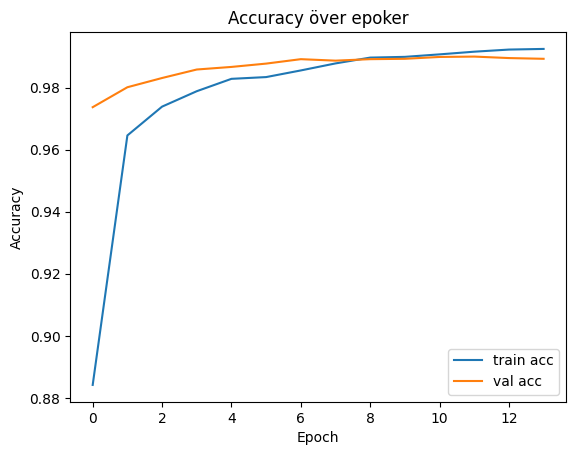

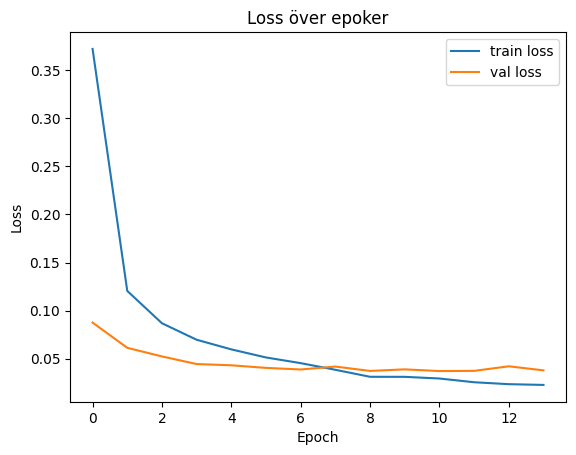

In [31]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy över epoker')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss över epoker')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


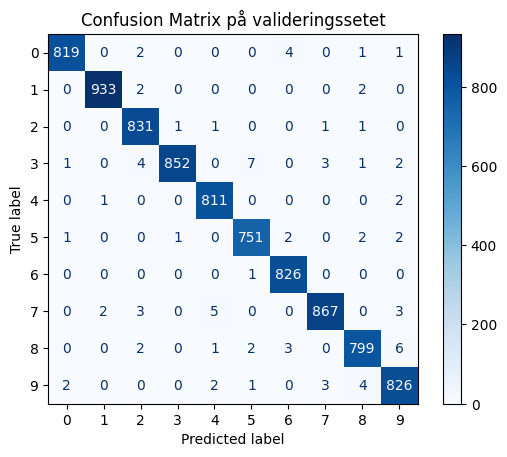

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Hämta prediktioner
preds_val = model.predict(X_val).argmax(axis=1)

# Skapa och visa CM
cm = confusion_matrix(y_val, preds_val)
disp = ConfusionMatrixDisplay(cm, display_labels=range(10))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix på valideringssetet')
plt.show()


In [34]:
import pandas as pd

# Gör prediktioner på X_test
preds_test = model.predict(X_test).argmax(axis=1)

# Packa i DataFrame
submission = pd.DataFrame({
    'ImageId': np.arange(1, len(preds_test)+1),
    'Label': preds_test
})

# Spara CSV
submission.to_csv('../outputs/submission.csv', index=False)
print("Saved ../outputs/submission.csv")


875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Saved ../outputs/submission.csv


In [35]:
model.save('..\mnist_cnn.keras')
